<a href="https://colab.research.google.com/github/yaminigangu/XAI_lab_pratical/blob/main/XAI_Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== FACEBOOK COSMETIC BRAND METRICS - SHAP ANALYSIS ===

1. LOADING AND EXPLORING THE DATASET
--------------------------------------------------
Dataset shape: (500, 19)
Number of rows: 500
Number of features: 19

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 19 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Page total likes                                                     500 non-null    int64  
 1   Type                                                                 500 non-null    object 
 2   Category                                                             500 non-null    int64  
 3   Post Month                                                           500 non-null    int64  
 4   Post Weekday                                                         500 non-nu

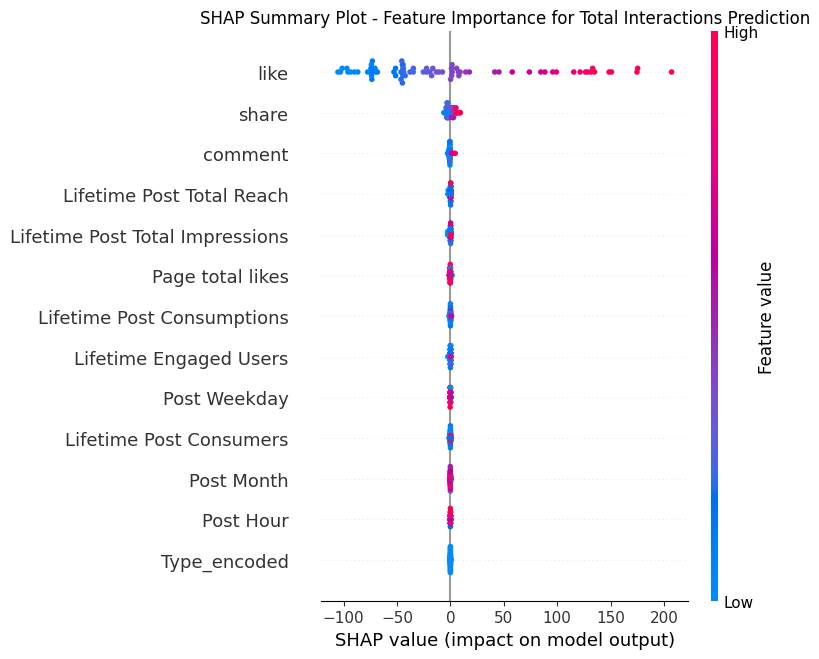


Feature Importance Comparison:
----------------------------------------
Top 5 Features by SHAP Importance:
                            feature  shap_importance
10                             like        64.167247
11                            share         2.926661
9                           comment         0.868798
4         Lifetime Post Total Reach         0.388755
5   Lifetime Post Total Impressions         0.372901

Comparison - Built-in vs SHAP Importance:
                            feature  importance  shap_importance  rf_rank  \
0                              like    0.980570        64.167247      1.0   
1                             share    0.005614         2.926661      2.0   
5                           comment    0.002028         0.868798      6.0   
3         Lifetime Post Total Reach    0.002234         0.388755      4.0   
2   Lifetime Post Total Impressions    0.002346         0.372901      3.0   
8                  Page total likes    0.000818         0.297683     

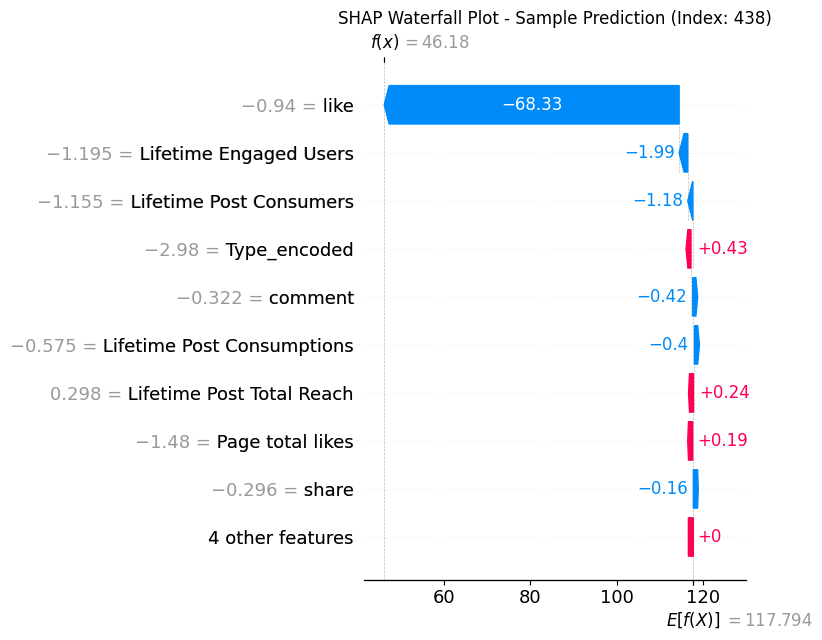

Generating SHAP Force Plot...


<Figure size 1600x400 with 0 Axes>

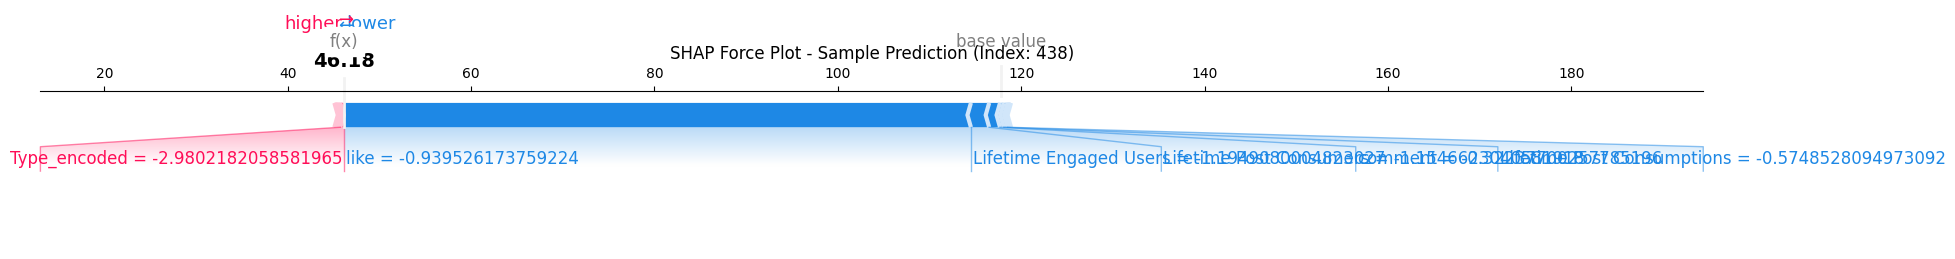

7. DETAILED INTERPRETATION
--------------------------------------------------
TOP 5 MOST INFLUENTIAL FEATURES (by SHAP):

11. like
   SHAP Importance: 64.1672
   Feature Mean: 0.0096
   Correlation with Target: 0.9912
   Interpretation: Like count is a direct engagement metric

12. share
   SHAP Importance: 2.9267
   Feature Mean: 0.0244
   Correlation with Target: 0.8224
   Interpretation: Shares represent content virality potential

10. comment
   SHAP Importance: 0.8688
   Feature Mean: -0.0090
   Correlation with Target: 0.4164
   Interpretation: Comments indicate deeper user engagement

5. Lifetime Post Total Reach
   SHAP Importance: 0.3888
   Feature Mean: 0.1689
   Correlation with Target: 0.4460
   Interpretation: Post reach indicates content visibility

6. Lifetime Post Total Impressions
   SHAP Importance: 0.3729
   Feature Mean: 0.1923
   Correlation with Target: 0.4991
   Interpretation: Impressions show content exposure frequency



In [1]:
# Facebook Cosmetic Brand Metrics - SHAP Feature Importance Analysis
# Assignment: Explainable AI using SHAP
# Dataset: Facebook Metrics of Cosmetic Brand

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("=== FACEBOOK COSMETIC BRAND METRICS - SHAP ANALYSIS ===")
print()

# 1. DATA LOADING AND EXPLORATION
print("1. LOADING AND EXPLORING THE DATASET")
print("-" * 50)

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Facebook Metrics of Cosmetic Brand.csv', index_col=0)
print(f"Dataset shape: {df.shape}")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")
print()

# Display basic information
print("Dataset Info:")
print(df.info())
print()

print("First 5 rows:")
print(df.head())
print()

print("Statistical Summary:")
print(df.describe())
print()

# Check for missing values
print("Missing Values:")
print(df.isnull().sum())
print()

# 2. DATA PREPROCESSING
print("2. DATA PREPROCESSING")
print("-" * 50)

# Handle missing values
print("Handling missing values...")
# Fill missing values with median for numerical columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    if df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)
        print(f"Filled missing values in {col}")

# Encode categorical variables
print("\nEncoding categorical variables...")
le = LabelEncoder()
if 'Type' in df.columns:
    df['Type_encoded'] = le.fit_transform(df['Type'])
    print("Encoded 'Type' column")

# Remove duplicates
print(f"\nRemoving duplicates...")
initial_rows = len(df)
df = df.drop_duplicates()
final_rows = len(df)
print(f"Removed {initial_rows - final_rows} duplicate rows")

# Handle outliers using IQR method
print("\nHandling outliers using IQR method...")
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply outlier removal to key metrics
key_columns = ['Lifetime Post Total Reach', 'Lifetime Post Total Impressions', 'Total Interactions']
for col in key_columns:
    if col in df.columns:
        initial_len = len(df)
        df = remove_outliers_iqr(df, col)
        removed = initial_len - len(df)
        if removed > 0:
            print(f"Removed {removed} outliers from {col}")

print(f"\nFinal dataset shape after preprocessing: {df.shape}")
print()

# 3. FEATURE SELECTION AND TARGET DEFINITION
print("3. FEATURE SELECTION AND TARGET DEFINITION")
print("-" * 50)

# Define target variable - we'll predict Total Interactions (user engagement)
target = 'Total Interactions'
print(f"Target variable: {target}")

# Select features for the model
feature_columns = [
    'Page total likes', 'Post Month', 'Post Weekday', 'Post Hour',
    'Lifetime Post Total Reach', 'Lifetime Post Total Impressions',
    'Lifetime Engaged Users', 'Lifetime Post Consumers', 'Lifetime Post Consumptions',
    'comment', 'like', 'share'
]

# Add encoded categorical variable
if 'Type_encoded' in df.columns:
    feature_columns.append('Type_encoded')

# Ensure all feature columns exist in the dataset
available_features = [col for col in feature_columns if col in df.columns]
print(f"Selected features ({len(available_features)}): {available_features}")

# Prepare feature matrix and target vector
X = df[available_features].copy()
y = df[target].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print()

# 4. MODEL BUILDING
print("4. MODEL BUILDING")
print("-" * 50)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=available_features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=available_features, index=X_test.index)

# Build Random Forest model
print("\nTraining Random Forest Regressor...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)
print("Model training completed!")

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# 5. MODEL EVALUATION
print("\n5. MODEL EVALUATION")
print("-" * 50)

# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Calculate additional metrics
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mpe = np.mean((y_test - y_pred) / y_test) * 100

print(f"MAPE: {mape:.4f}%")
print(f"MPE: {mpe:.4f}%")
print()

# Built-in feature importance
print("Built-in Feature Importance (Random Forest):")
feature_importance = pd.DataFrame({
    'feature': available_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance)
print()

# 6. SHAP ANALYSIS
print("6. SHAP ANALYSIS")
print("-" * 50)

print("Initializing SHAP TreeExplainer...")
explainer = shap.TreeExplainer(rf_model)

print("Computing SHAP values for test set...")
# Compute SHAP values as an Explanation object
shap_values = explainer(X_test_scaled)


print("SHAP values computation completed!")
print(f"SHAP values shape: {shap_values.shape}")
print()

# SHAP Summary Plot
print("Generating SHAP Summary Plot...")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_scaled, feature_names=available_features, show=False)
plt.title('SHAP Summary Plot - Feature Importance for Total Interactions Prediction')
plt.tight_layout()
plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature Importance Comparison
print("\nFeature Importance Comparison:")
print("-" * 40)

# SHAP feature importance (mean absolute SHAP values)
shap_importance = pd.DataFrame({
    'feature': available_features,
    'shap_importance': np.abs(shap_values.values).mean(axis=0)
}).sort_values('shap_importance', ascending=False)

print("Top 5 Features by SHAP Importance:")
print(shap_importance.head())
print()

print("Comparison - Built-in vs SHAP Importance:")
comparison_df = feature_importance.merge(shap_importance, on='feature')
comparison_df['rf_rank'] = comparison_df['importance'].rank(ascending=False)
comparison_df['shap_rank'] = comparison_df['shap_importance'].rank(ascending=False)
print(comparison_df.sort_values('shap_importance', ascending=False))
print()

# SHAP Waterfall Plot for a single prediction
print("Generating SHAP Waterfall Plot for sample prediction...")
sample_idx = 0
plt.figure(figsize=(12, 8))
shap.waterfall_plot(shap_values[sample_idx], show=False)
plt.title(f'SHAP Waterfall Plot - Sample Prediction (Index: {X_test_scaled.index[sample_idx]})')
plt.tight_layout()
plt.savefig('shap_waterfall_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# SHAP Force Plot (save as static image)
print("Generating SHAP Force Plot...")
plt.figure(figsize=(16, 4))
shap.force_plot(explainer.expected_value, shap_values.values[sample_idx], X_test_scaled.iloc[sample_idx],
                matplotlib=True, show=False)
plt.title(f'SHAP Force Plot - Sample Prediction (Index: {X_test_scaled.index[sample_idx]})')
plt.tight_layout()
plt.savefig('shap_force_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# 7. DETAILED INTERPRETATION
print("7. DETAILED INTERPRETATION")
print("-" * 50)

print("TOP 5 MOST INFLUENTIAL FEATURES (by SHAP):")
print("=" * 45)

top_5_features = shap_importance.head().copy()
for idx, row in top_5_features.iterrows():
    feature_name = row['feature']
    importance_score = row['shap_importance']

    # Get feature statistics
    feature_mean = X_test_scaled[feature_name].mean()
    feature_corr = X_test_scaled[feature_name].corr(y_test)

    print(f"\n{idx+1}. {feature_name}")
    print(f"   SHAP Importance: {importance_score:.4f}")
    print(f"   Feature Mean: {feature_mean:.4f}")
    print(f"   Correlation with Target: {feature_corr:.4f}")

    # Domain-specific interpretation
    if 'like' in feature_name.lower():
        print("   Interpretation: Like count is a direct engagement metric")
    elif 'reach' in feature_name.lower():
        print("   Interpretation: Post reach indicates content visibility")
    elif 'impression' in feature_name.lower():
        print("   Interpretation: Impressions show content exposure frequency")
    elif 'comment' in feature_name.lower():
        print("   Interpretation: Comments indicate deeper user engagement")
    elif 'share' in feature_name.lower():
        print("   Interpretation: Shares represent content virality potential")
    elif 'hour' in feature_name.lower():
        print("   Interpretation: Posting time affects audience availability")
    else:
        print("   Interpretation: Significant predictor of user engagement")

print("\n" + "="*60)